# Assignment 2 Machine Learning 2020:
### Objective: Build multiple ML models that can identify handwritten digits [0-9] correctly 
Created by:Austin Diodene

Date:10/1/2020

Email:austinodiodene@gmail.com

**Step 1) Understand the Data**

The MNIST dataset is a computer vision data set that consists of 28 by 28 pixel images of *handwritten* numbers [1-9].These means each image will be expressed as a 28 by 28 array. In this array lies values bewteen 0-255 which are greyscale values. 0 is white, 255 is black, and all other values are a combination. The data set is broken up like so; $D = 
(x_{i},y_{i})$ where, $x_{i}$ is a 28 by 28 pixel array and $y_{i}$ is its array position with respect to other pictures. 

**Step 2) Aquire the Data**

We are going to use tensorflow and pull our data from the keras library. The keras library stores the information as a tuple of numpy arrays. The actual MNIST data is in a .idx form, which "is a simple format for vectors and multidimensional matrices of various numerical types." Cited from: http://yann.lecun.com/exdb/mnist/

In [2]:
# Import modules
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage.feature import hog
from skimage import data, exposure
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import time

In [3]:
# Unpack data set into training and testing variables
(x_train, y_train),(x_test, y_test) = mnist.load_data()
print(y_train.shape ,y_test.shape)

(60000,) (10000,)


**Step 3) Pre-processing**  

Breakdown the distribution of the given data to understand it. Print a mulititude of samples knowing it is pixel data. We find the original shape to be $(# of samples, rows of pixels, columns of pixels)$. Normalize to make the computation and convergence smoother. Given the assignment goals, the data was resized to both $7x7$ and $14x14$. The HOG features are then extracted to use for further analysis. Lastly, the data was flattend to run through common ML algorithms. These pictures show the quality decrease upon resizing,  

!['Original'](img/28by28.png)
!['14by14'](img/14by14.png)
!['7by7'](img/7by7.png)

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
Original shape:((60000, 28, 28), (10000, 28, 28))
14 by 14 shape:((60000, 14, 14), (10000, 14, 14))
7 by 7 shape:((60000, 7, 7), (10000, 7, 7))


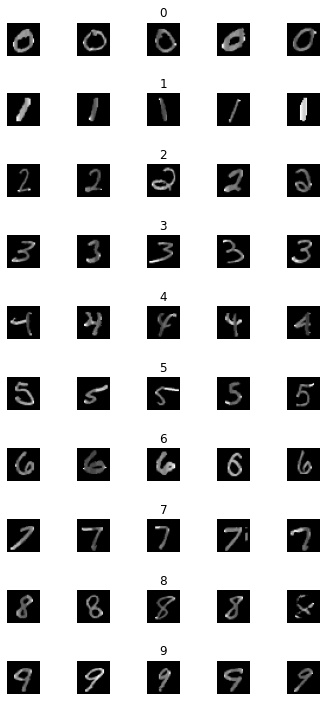

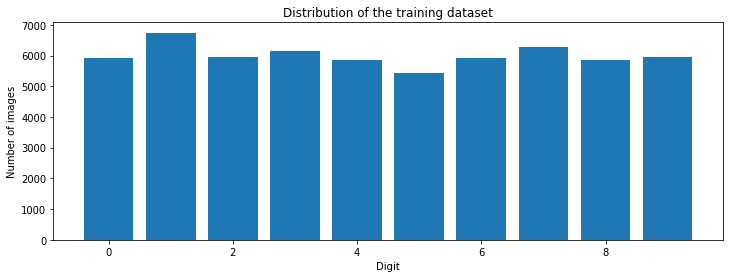

In [23]:
# Display distribution of training images
num_of_samples = []
cols = 5
num_of_classes = 10 #each digit total: 10

fig, axs = plt.subplots(nrows=num_of_classes, ncols=cols,
                       figsize=(5, 10))
fig.tight_layout()
for i in range(cols):
  for j in range(num_of_classes):
    x_selected = x_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected -1)),
                                :, :],
                    cmap=plt.get_cmap('gray')) 
    axs[j][i].axis("off")
    if i==2:
      axs[j][i].set_title(str(j))
      num_of_samples.append(len(x_selected))
        
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_of_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Digit")
plt.ylabel("Number of images")
[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

# Normalize the data between 0-1
x_train = tf.keras.utils.normalize(x_train, axis = 1)
x_test = tf.keras.utils.normalize(x_test, axis = 1)
print(f'Original shape:{x_train.shape, x_test.shape}') # Original shape of test/train sets

# Reshape to 7x7 and 14x14
# 14x14
x_traint = x_train.transpose(1,2,0)  #Bring the batch channel to the end (28,28,2)
x_train_resize = tf.image.resize(x_traint, (14,14)).numpy() #apply resize (14,14,2)
x_train14 = x_train_resize.transpose(2,0,1) #bring the batch channel back to front (2,14,14)
x_testt = x_test.transpose(1,2,0)  
x_test_resize = tf.image.resize(x_testt, (14,14)).numpy() 
x_test14 = x_test_resize.transpose(2,0,1) 
print(f'14 by 14 shape:{x_train14.shape, x_test14.shape}') # sanity check

# 7x7
x_traint = x_train.transpose(1,2,0)  #Bring the batch channel to the end (28,28,2)
x_train_resize = tf.image.resize(x_traint, (7,7)).numpy() #apply resize (14,14,2)
x_train7 = x_train_resize.transpose(2,0,1) #bring the batch channel back to front (2,14,14)
x_testt = x_test.transpose(1,2,0)  
x_test_resize = tf.image.resize(x_testt, (7,7)).numpy() 
x_test7 = x_test_resize.transpose(2,0,1) 
print(f'7 by 7 shape:{x_train7.shape, x_test7.shape}') # sanity check

# Calculate HOG features and fill an array [picture #, HOG features]
hog_features = np.empty([60000,432]) 
for i in range(len(x_train14)):
    fd = hog(x_train14[i], orientations=3, pixels_per_cell=(2, 2), 
        cells_per_block=(2, 2), visualize=False, multichannel=False)
    hog_features[i,:] = fd

# We are not given HOG features to test so we must make them
hog_features_test = np.empty([10000,432]) 
for i in range(len(x_test14)):
    fd = hog(x_test14[i], orientations=3, pixels_per_cell=(2, 2), 
        cells_per_block=(2, 2), visualize=False, multichannel=False)
    hog_features_test[i,:] = fd
    
# Flatten data for sklearn alg
image_vector_size = 196
x_train14 = x_train14.reshape(x_train.shape[0], image_vector_size)
x_test14 = x_test14.reshape(x_test.shape[0], image_vector_size)

image_vector_size = 49
x_train7 = x_train7.reshape(x_train.shape[0], image_vector_size)
x_test7 = x_test7.reshape(x_test.shape[0], image_vector_size)

**Step 4) Run Machine Learning Models**  

Run multinomial Logistic Regression, SVM, and random forest models all while clocking run time. 

In [10]:
# Run sklearn logistic regression model
start = time.time()
LR14by14 = LogisticRegression(random_state=0, max_iter = 400).fit(x_train14, y_train)
stop = time.time()
print(f"14 by 14 Multinomial Logistic Regression Training time: {stop - start}s")

14 by 14 Multinomial Logistic Regression Training time: 21.521076440811157s


In [18]:
start = time.time()
LR7by7 = LogisticRegression(random_state=0, max_iter = 400).fit(x_train7, y_train)
stop = time.time()
print(f"7 by 7 Multinomial Logistic Regression Training time: {stop - start}s")

7 by 7 Multinomial Logistic Regression Training time: 12.620484828948975s


In [21]:
start = time.time()
LRhog = LogisticRegression(random_state=0, max_iter = 1000).fit(hog_features, y_train)
stop = time.time()
print(f"HOG Multinomial Logistic Regression Training time: {stop - start}s")

HOG Multinomial Logistic Regression Training time: 91.07671570777893s


In [9]:
# Run sklearn SVM 
start = time.time()
SVM14by14 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVM14by14.fit(x_train14, y_train)
stop = time.time()
print(f"14 by 14 SVM Training time: {stop - start}s")

14 by 14 SVM Training time: 181.08030080795288s


In [29]:
start = time.time()
SVM7by7 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVM7by7.fit(x_train7, y_train)
stop = time.time()
print(f"7 by 7 SVM Training time: {stop - start}s")

7 by 7 SVM Training time: 96.86630201339722s


In [32]:
start = time.time()
SVMhog = make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVMhog.fit(hog_features, y_train)
stop = time.time()
print(f"HOG SVM Training time: {stop - start}s")

HOG SVM Training time: 276.45962262153625s


In [35]:
# Run sklearn Random Forest
start = time.time()
RF14by14 = RandomForestRegressor(random_state=0)
RF14by14.fit(x_train14, y_train)
stop = time.time()
print(f"14 by 14 RF Training time: {stop - start}s")

14 by 14 RF Training time: 502.8585534095764s


In [45]:
start = time.time()
RF7by7 = RandomForestRegressor(random_state=0)
RF7by7.fit(x_train7, y_train)
stop = time.time()
print(f"7 by 7 RF Training time: {stop - start}s")

7 by 7 RF Training time: 102.0440583229065s


In [5]:
start = time.time()
RFhog = RandomForestRegressor(random_state=0)
RFhog.fit(hog_features, y_train)
stop = time.time()
print(f"HOG RF Training time: {stop - start}s")

HOG RF Training time: 1542.8098630905151s


**Step 5) Evaluate model accuracy**

In [16]:
LR14by14predict  = LR14by14.predict(x_test14)
LR14by14acc = accuracy_score(y_test,LR14by14predict)
print(f"Accuracy score for 14 by 14 Multinomial Logistic Regression: {LR14by14acc}")

Accuracy score for 14 by 14 Multinomial Logistic Regression: 0.9229


In [19]:
LR7by7predict  = LR7by7.predict(x_test7)
LR7by7acc = accuracy_score(y_test,LR7by7predict)
print(f"Accuracy score for 7 by 7 Multinomial Logistic Regression: {LR7by7acc}")

Accuracy score for 7 by 7 Multinomial Logistic Regression: 0.828


In [25]:
LRhogpredict = LRhog.predict(hog_features_test)
LRhogacc = accuracy_score(y_test,LRhogpredict)
print(f"Accuracy score for HOG Multinomial Logistic Regression: {LRhogacc}")

Accuracy score for HOG Multinomial Logistic Regression: 0.9625


In [27]:
SVM14by14predict = SVM14by14.predict(x_test14)
SVM14by14acc = accuracy_score(y_test, SVM14by14predict)
print(f"Accuracy score for 14 by 14 SVM: {SVM14by14acc}")

Accuracy score for 14 by 14 SVM: 0.9688


In [30]:
SVM7by7predict = SVM7by7.predict(x_test7)
SVM7by7acc = accuracy_score(y_test,SVM7by7predict)
print(f"Accuracy score for 7 by 7 SVM: {SVM7by7acc}")

Accuracy score for 7 by 7 SVM: 0.9224


In [33]:
SVMhogpredict = SVMhog.predict(hog_features_test)
SVMhogacc = accuracy_score(y_test, SVMhogpredict)
print(f"Accuracy score for HOG SVM: {SVMhogacc}")

Accuracy score for HOG SVM: 0.9724


In [43]:
RF14by14predict = RF14by14.predict(x_test14)
RF14by14acc = RF14by14.score(x_test14, y_test)
print(f"Accuracy score for 14 by 14 RF: {RF14by14acc}")

Accuracy score for 14 by 14 RF: 0.9091132395700917


In [46]:
RF7by7predict = RF7by7.predict(x_test7)
RF7by7acc = RF7by7.score(x_test7, y_test)
print(f"Accuracy score for 7 by 7 RF: {RF7by7acc}")

Accuracy score for 7 by 7 RF: 0.8598067524819967


In [48]:
RFhogpredict = RFhog.predict(hog_features_test)
RFhogacc = RFhog.score(hog_features_test, y_test)
print(f"Accuracy score for HOG RF: {RFhogacc}")

Accuracy score for HOG RF: 0.8823093749727347


**Conclusion**  
The models were made, used to predict the test data, and compared to the provided labels. The results are tabulated below.  
![results](img/results.png)  
The results show a consistent increase in training time with a higher number of features. Almost all Random forest models are significantly longer to train than SVC or MLR. The highest acheivable accuracy was 97.2 percent with HOG features of 14 by 14 images using MLR. *This shows that an efficent training run of the MNIST data set could be achieved within 2 minutes using Multinomial Logistic Regression.*

**References**  
Tensor flow environment creation- https://www.anaconda.com/blog/tensorflow-in-anaconda 
Reshape function-  https://stackoverflow.com/questions/63326056/how-to-reshape-the-mnist-train-images-from-60000-28-28-to-60000-16-16  
Distribution of test images- https://medium.com/@afozbek_/how-to-train-a-model-with-mnist-dataset-d79f8123ba84  
HOG Features- https://github.com/holtzhau/scikits.image/blob/master/skimage/feature/hog.py#L52  
Sklearn Logistic Regression- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
Accuracy model- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html  
SVC Model- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html  
Random Forrest Regressor- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html